*First compiled: May 2, 2017.*

# Graph abstraction for data of [Paul *et al.*, Cell (2015)](https://doi.org/10.1016/j.cell.2015.11.013)

Here, we trace myeloid differentiation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy.api as sc

sc.settings.verbosity = 2                # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)    # low pixel number yields small inline figures
sc.logging.print_version_and_date()

Running Scanpy 0.3 on 2017-11-17 02:10.


## Preprocessing

In [2]:
adata = sc.datasets.paul15_raw()
sc.write('paul15_raw', adata)
sc.pp.recipe_zheng17(adata, plot=False)
sc.write('paul15', adata)

... storing paul15_clusters as categorical type
normalizing by total count per cell
    finished (0:00:00.064): normalized adata.X and added
    'n_counts_all', counts per cell before normalization (adata.smp)
filter highly variable genes by dispersion and mean (0:00:00.061)
normalizing by total count per cell
    finished (0:00:00.018): normalized adata.X and added
    'n_counts', counts per cell before normalization (adata.smp)


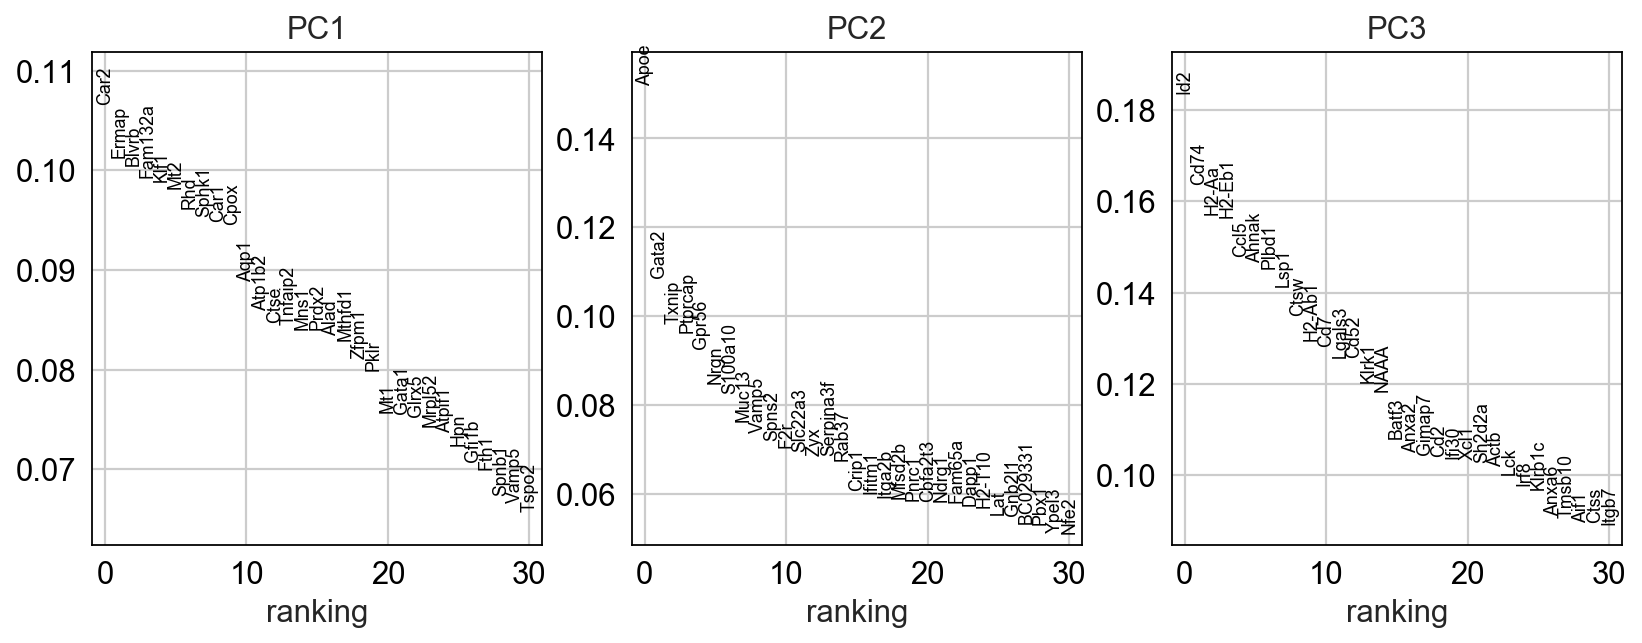

In [3]:
sc.tl.pca(adata)
sc.pl.pca_loadings(adata)

## Visualization

In [4]:
adata = sc.read('paul15')
sc.tl.tsne(adata, n_pcs=30)
sc.write('paul15', adata)

computing tSNE
    preprocess using PCA with 30 PCs
    using 30 principal components
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:00:09.343):  added
    "X_tsne", tSNE coordinates (adata.smp)


... you are using a very low resolution for saving figures, adjusting to dpi=300
saving figure to file ./figures/tsne.png


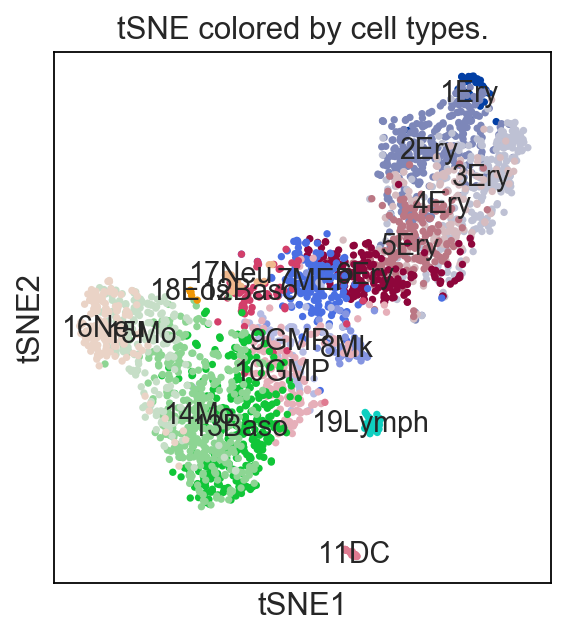

In [5]:
adata = sc.read('paul15')
ax = sc.pl.tsne(adata, color='paul15_clusters',
               title='tSNE colored by cell types.',
                palette=sc.pl.palettes.default_26, legend_loc='on data',
                save=True)

Let us also visualize the data using the Fruchterman-Reingold algorithm.

In [6]:
adata = sc.read('paul15')
sc.tl.draw_graph(adata, n_neighbors=4, recompute_graph=True)
sc.write('paul15', adata)

drawing single-cell graph using layout "fr"
    compute "X_pca" for building graph
    computing data graph with n_neighbors = 4 
    computing spectral decomposition ("diffmap") with 15 components
    eigenvalues of transition matrix
    [ 1.            0.9966393709  0.9943132997  0.9864672422  0.981000483
      0.9788661599  0.978161633   0.9748940468  0.9719734192  0.9651904702
      0.9590314627  0.952006042   0.9453957081  0.9388744831  0.9358919263]
    finished (0:01:05.462) and added
    "X_draw_graph_fr", graph_drawing coordinates (adata.smp)
    "draw_graph_params", the parameters (adata.uns)


saving figure to file ./figures/draw_graph_fr.png


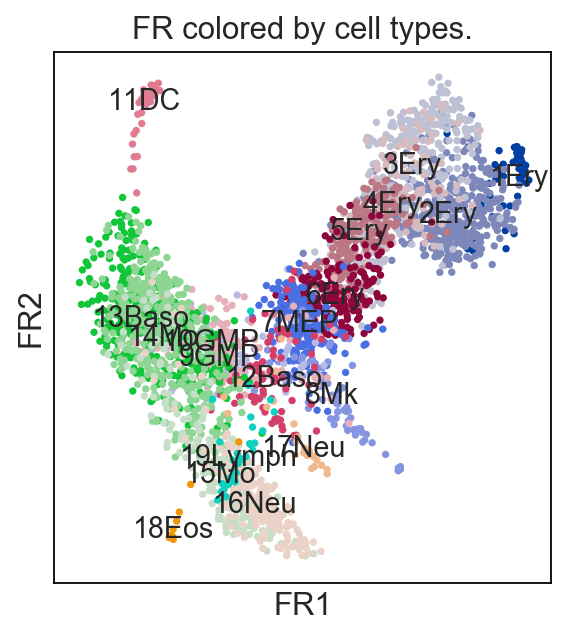

In [7]:
ax = sc.pl.draw_graph(adata, color='paul15_clusters',
                      title='FR colored by cell types.',
                      palette=sc.pl.palettes.default_26, legend_loc='on data',
                      save=True)

Apparently, using the default settings, FR resolves the heterogeneity nicer than tSNE.

## Estimate connectivity of cell groups using graph abstraction

In [8]:
adata = sc.read('paul15')
adata.uns['iroot'] = np.flatnonzero(adata.smp['paul15_clusters']  == '7MEP')[0]
sc.tl.aga(adata,
          n_neighbors=4,
          resolution=1.2)
sc.write('paul15', adata)

running Louvain clustering
    using "X_pca" for building graph
    using stored data graph with n_neighbors = 4 and spectrum
    [ 1.            0.9966393709  0.9943132997  0.9864672422  0.981000483
      0.9788661599  0.978161633   0.9748940468  0.9719734192  0.9651904702]
    using the "louvain" package of Traag (2017)
    finished (0:00:00.167): found 16 clusters and added
    'louvain_groups', the cluster labels (adata.smp, dtype=category)
running Approximate Graph Abstraction (AGA)
    using "X_pca" for building graph
    using stored data graph with n_neighbors = 4 and spectrum
    [ 1.            0.9966393709  0.9943132997  0.9864672422  0.981000483
      0.9788661599  0.978161633   0.9748940468  0.9719734192  0.9651904702]
    abstracted graph will have 16 nodes
    finished (0:00:00.506)


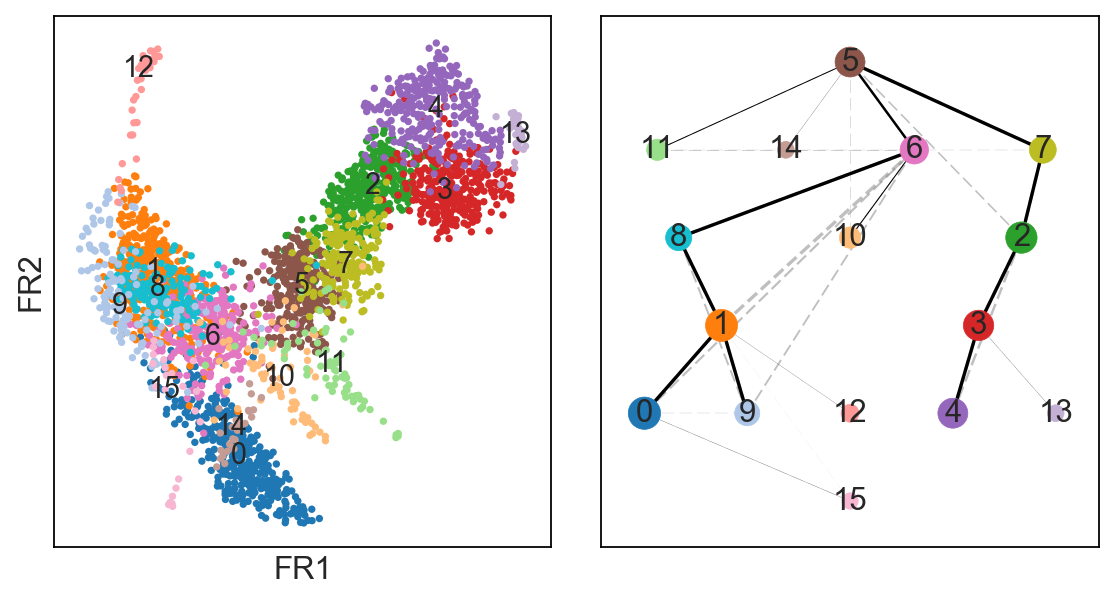

In [9]:
adata = sc.read('paul15')
axs = sc.pl.aga(adata, title='',
                basis='draw_graph_fr',
                root=5, layout='eq_tree')

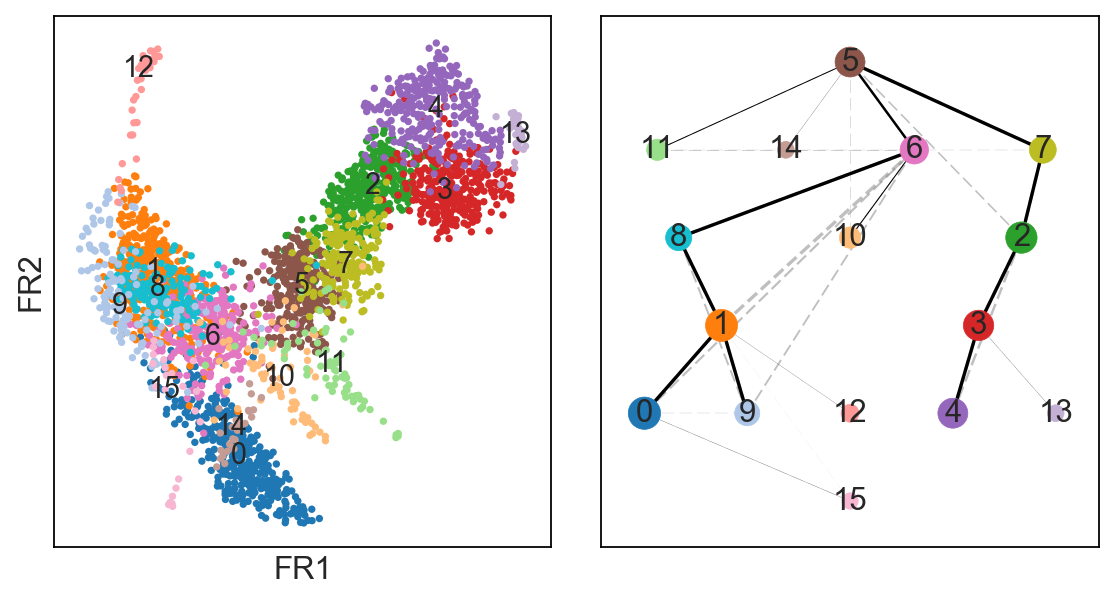

In [10]:
adata = sc.read('paul15')
axs = sc.pl.aga(adata, title='',
                basis='draw_graph_fr',
                root=5, layout='eq_tree')

exporting to ./write/aga_graph.gexf


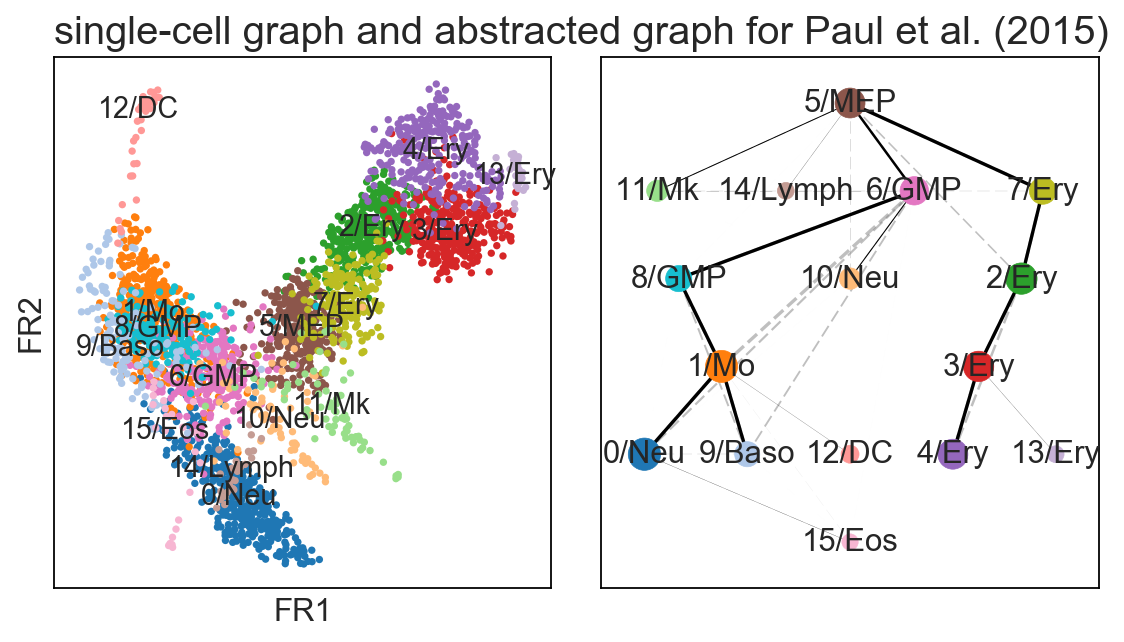

In [11]:
import re
adata = sc.read('paul15')
aga_groups = adata.uns['aga_groups_key']
asso_names, _ = sc.utils.compute_association_matrix_of_groups(
    adata, prediction=aga_groups, reference='paul15_clusters',
    normalization='reference', max_n_names=1)
adata.smp[aga_groups].cat.categories = [
    '{}/{}'.format(name, re.sub('\d+', '', asso_names[iname]))  # replace integers
     for iname, name in enumerate(adata.smp[aga_groups].cat.categories)]
axs = sc.pl.aga(adata, title='', threshold_dashed=None,
                basis='draw_graph_fr',
                root=5,
                layout='eq_tree', show=False,
                export_to_gexf=True)
axs[0].set_title('single-cell graph and abstracted graph for Paul et al. (2015)', loc='left', fontsize=18)
pl.savefig('./figures/aga.png', dpi=300)
pl.show()

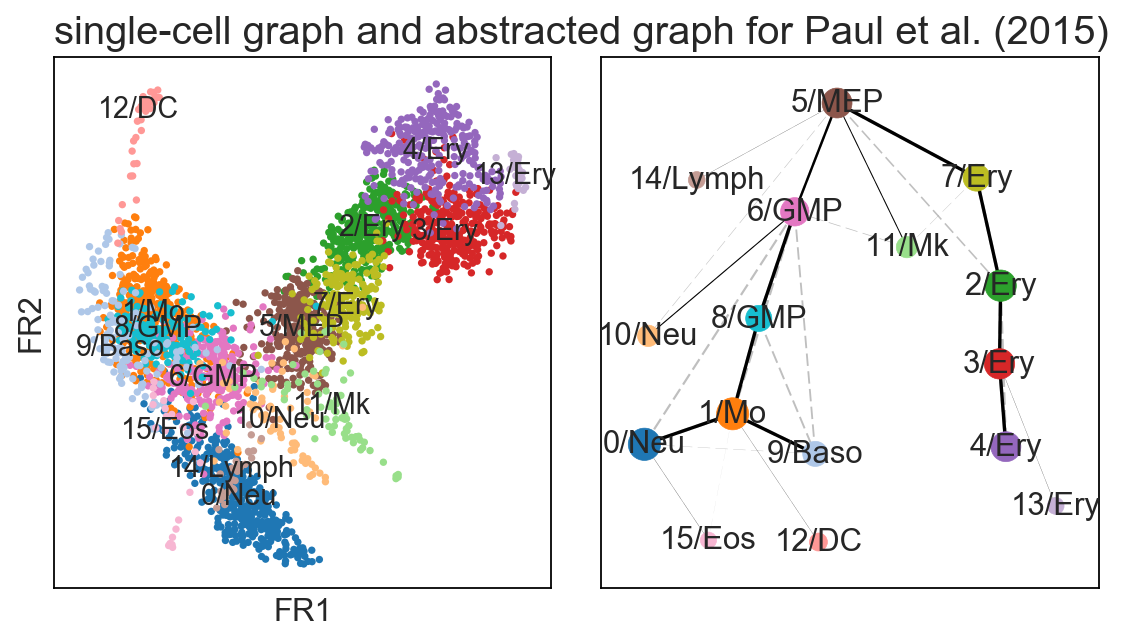

In [12]:
axs = sc.pl.aga(adata, title='', threshold_dashed=0.01,
                basis='draw_graph_fr',
                root=5, show=False,
                pos='./write/aga_graph_gephi.gdf')
axs[0].set_title('single-cell graph and abstracted graph for Paul et al. (2015)',
                 loc='left', fontsize=18)
pl.savefig('./figures/aga_gephi.svg')
pl.show()

saving figure to file ./figures/aga_graph.png


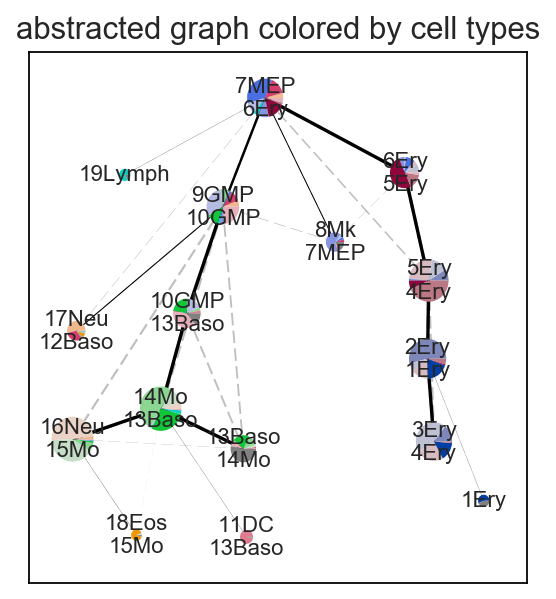

In [13]:
asso_names, asso_matrix = sc.utils.compute_association_matrix_of_groups(
    adata, prediction=aga_groups, reference='paul15_clusters', normalization='reference')
asso_colors = sc.utils.get_associated_colors_of_groups(sc.pl.palettes.default_26, asso_matrix)
ax = sc.pl.aga_graph(adata, threshold_dashed=0.01,
                     title='abstracted graph colored by cell types',
                     root=0, layout='eq_tree',
                     color=asso_colors, groups=asso_names,
                     fontsize=10, save=True, pos='./write/aga_graph_gephi.gdf')

## Reconstruct gene changes for a given set of genes

Reconstruct the dynamics.

In [14]:
adata = sc.read('paul15')
adata_all_genes = sc.datasets.paul15_raw()
sc.pp.recipe_zheng17(adata_all_genes, n_top_genes=3000)
aga_groups = adata.uns['aga_groups_key']
adata_all_genes.smp[aga_groups] = adata.smp[aga_groups]
adata_all_genes.smp['aga_pseudotime'] = adata.smp['aga_pseudotime']

... storing paul15_clusters as categorical type
normalizing by total count per cell
    finished (0:00:00.064): normalized adata.X and added
    'n_counts_all', counts per cell before normalization (adata.smp)
filter highly variable genes by dispersion and mean (0:00:00.200)
normalizing by total count per cell
    finished (0:00:00.050): normalized adata.X and added
    'n_counts', counts per cell before normalization (adata.smp)


In [15]:
gene_names = ['Gata2', 'Gata1', 'Hba-a2', 'Gfi1', 'Elane', 'Irf8', 'Csf1r']

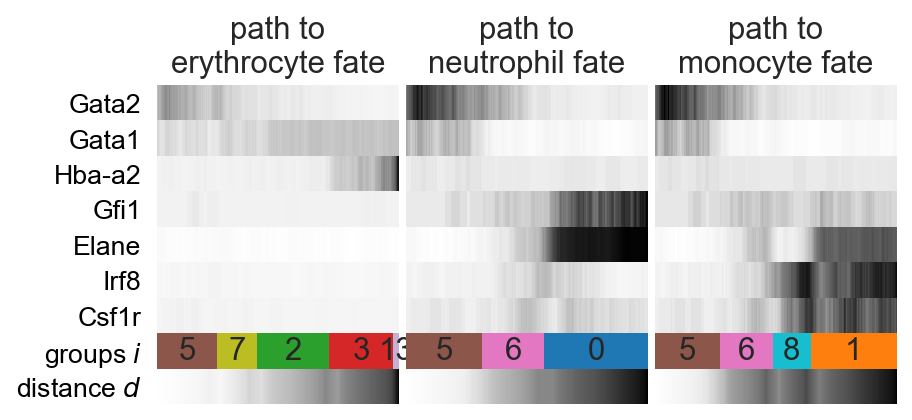

In [16]:
adata = sc.read('paul15')
paths = [('erythrocytes', [5, 7, 2, 3, 13]), 
         ('neutrophils', [5, 6, 0]), 
         ('monocytes', [5, 6, 8, 1])]
rcParams['figure.figsize'] = (6, 2.5)
rcParams['figure.subplot.top'] = 0.82
rcParams['figure.subplot.bottom'] = 0.2
rcParams['figure.subplot.right'] = 0.92
rcParams['figure.subplot.left'] = 0.05
_, axs = pl.subplots(ncols=3, gridspec_kw={'wspace': 0.03})
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.aga_path(adata_all_genes,
                             groups='louvain_groups',
                             ax=axs[ipath], ytick_fontsize=12,
                             left_margin=0.15,
                             nodes=path,
                             keys=gene_names,
                             n_avg=50,
                             show_yticks=True if ipath==0 else False,
                             show_colorbar=False,                             
                             title='path to\n{} fate'.format(descr[:-1]),
                             return_data=True, show=False)
    data.to_csv('./write/aga_path_{}.csv'.format(descr))
pl.savefig('./figures/aga_path.svg')
pl.show()
sc.pl.reset_rcParams()

## Compare the dynamics with the one obtained from Nestorowa *et al.* (2016)

In [17]:
import scipy as sp
import scipy.stats
import scipy.interpolate
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

In [18]:
dfs_nestorowa16_compare = []
dfs_paul15_compare = []
path_lengths = [0]
path_length_old = 0
for p in paths:
   df_paul15 = pd.read_csv('./write/aga_path_{}.csv'.format(p[0]))
   df_nestorowa16 = pd.read_csv('../nestorowa16/write/aga_path_{}.csv'.format(p[0]))
   x_nestorowa16 = np.linspace(0, 1, num=df_nestorowa16.shape[0])
   x_paul15 = np.linspace(0, 1, num=df_paul15.shape[0])
   df_paul15_compare = pd.DataFrame()
   df_nestorowa16_compare = pd.DataFrame() 
   for gene in gene_names:
       y = sp.interpolate.interp1d(x_paul15, df_paul15[gene])
       y = sc.utils.moving_average(y(x_nestorowa16), n=100)
       df_paul15_compare[gene] = y
       df_nestorowa16_compare[gene] = sc.utils.moving_average(df_nestorowa16[gene].values, n=100)
   path_lengths.append(df_nestorowa16_compare.shape[0] + path_length_old)
   path_length_old += df_nestorowa16_compare.shape[0]
   dfs_nestorowa16_compare.append(df_nestorowa16_compare)
   dfs_paul15_compare.append(df_paul15_compare)

In [19]:
df_nestorowa16_compare_merged = pd.concat(dfs_nestorowa16_compare, ignore_index=True)
df_paul15_compare_merged = pd.concat(dfs_paul15_compare, ignore_index=True)

Normalize scale.

In [20]:
df_nestorowa16_compare_merged = (df_nestorowa16_compare_merged - df_nestorowa16_compare_merged.mean()) / (df_nestorowa16_compare_merged.max() - df_nestorowa16_compare_merged.min())
df_paul15_compare_merged = (df_paul15_compare_merged - df_paul15_compare_merged.mean()) / (df_paul15_compare_merged.max() - df_paul15_compare_merged.min())

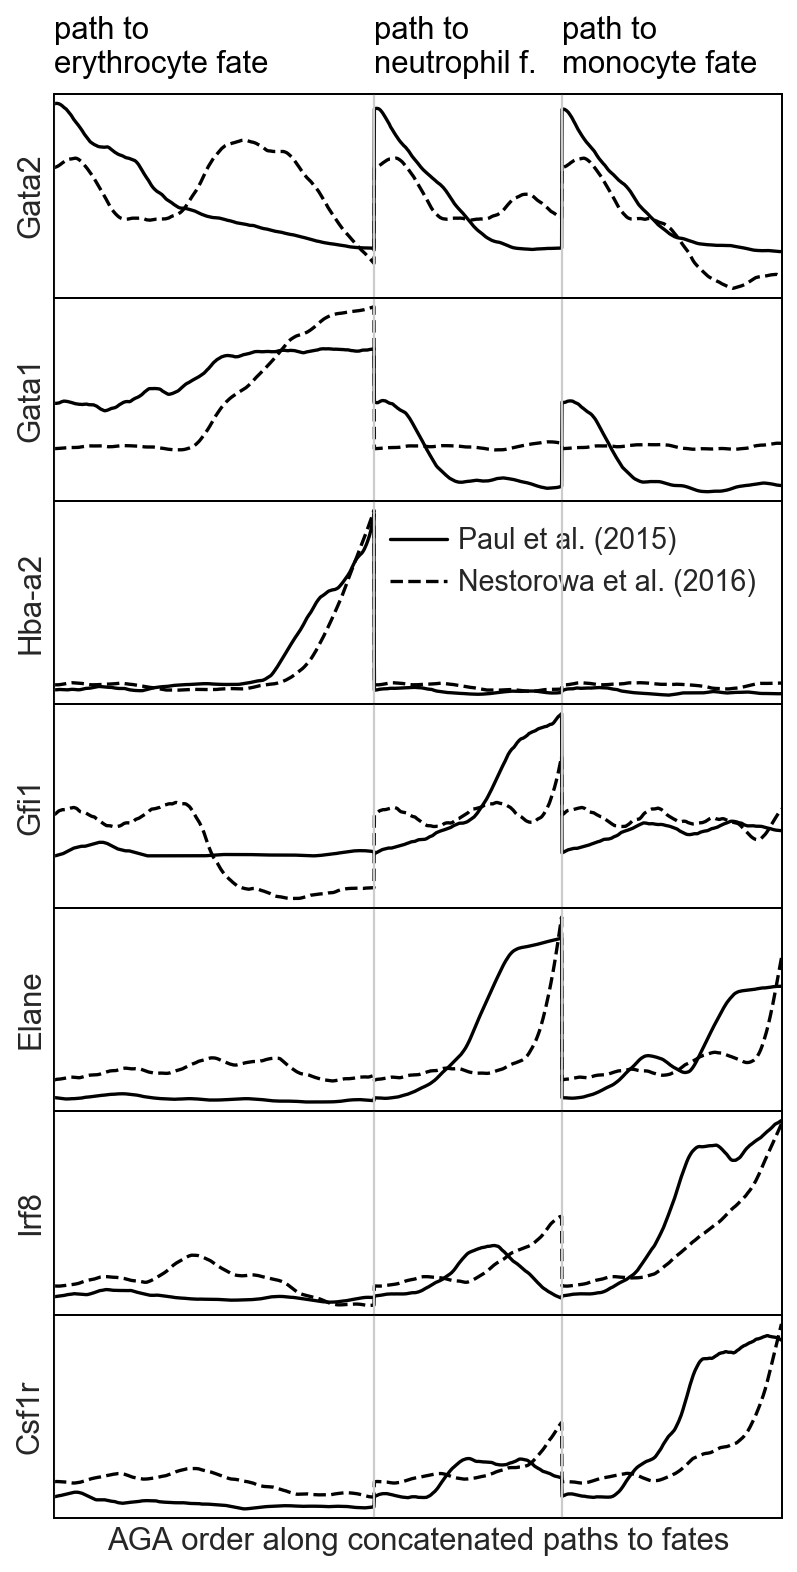

In [21]:
rcParams['figure.figsize'] = (5, 10)
rcParams['figure.subplot.left'] = 0.05
rcParams['figure.subplot.top'] = 0.95
rcParams['figure.subplot.bottom'] = 0.06

_, axs = pl.subplots(nrows=len(gene_names), gridspec_kw={'hspace': 0})
for igene, gene in enumerate(gene_names):
    nest = df_nestorowa16_compare_merged[gene].values
    paul = df_paul15_compare_merged[gene].values
    # all of the following distance measures are limited... 
    # tau, _ = sp.stats.kendalltau(nest, paul)  # strongly influenced by fluctuations
    # rho, _ = sp.stats.pearsonr(nest, paul)  # not appropriate, either
    # distance, _ = fastdtw(nest, paul, dist=euclidean)
    # scale = max(np.max(nest), np.max(paul) - min(np.min(nest), np.min(paul)))
    # print(gene, distance/scale/nest.size)
    pl.sca(axs[igene])
    pl.plot(paul, 'k', label='Paul et al. (2015)')
    pl.plot(nest, 'k--', label='Nestorowa et al. (2016)')    
    pl.grid(False)
    pl.ylabel(gene)
    if gene != gene_names[-1]:
        pl.xticks([])
    else:
        pl.xlabel('AGA order along concatenated paths to fates')
    if igene == 2:
        pl.legend(loc='upper right', handlelength=2)
    pl.xlim(0, len(paul))
    pl.xticks([])
    xlim = pl.xlim()
    pl.twiny()
    pl.xlim(pl.xlim(xlim))
    pl.xticks(path_lengths[:-1],                                                                                                                           
             ['path to\n{} '.format(p[0][:-1]) + ('fate' if p[0][:-1] != 'neutrophil' else 'f.')
              if gene == gene_names[0] else '' for p in paths],
              ha='left')
    pl.yticks([])
pl.savefig('./figures/aga_path_comparison.png', dpi=300)
pl.show()
sc.pl.reset_rcParams()